## Task 2 - Monthly solar prediction

In [50]:
# Load data 'datasolar.csv'

files <- dir("functions", full.names = TRUE)
for (i in 1:length(files)) source(files[i])
Y <- read.table("datasolar.csv", sep = ",", header = TRUE)

# Merge 'month' and 'year' columns into 'time'
Y$time <- Y$year + (Y$month - 1) / 12
Yts <- ts(Y[, 3], start = c(Y$year[1], Y$month[1]), frequency = 12)

mu <- 5.72
Xt <- log(Yts) - mu

# Set up AR and seasonal AR parameters
phi_1 <- -0.38
phi_seasonal <- -0.94


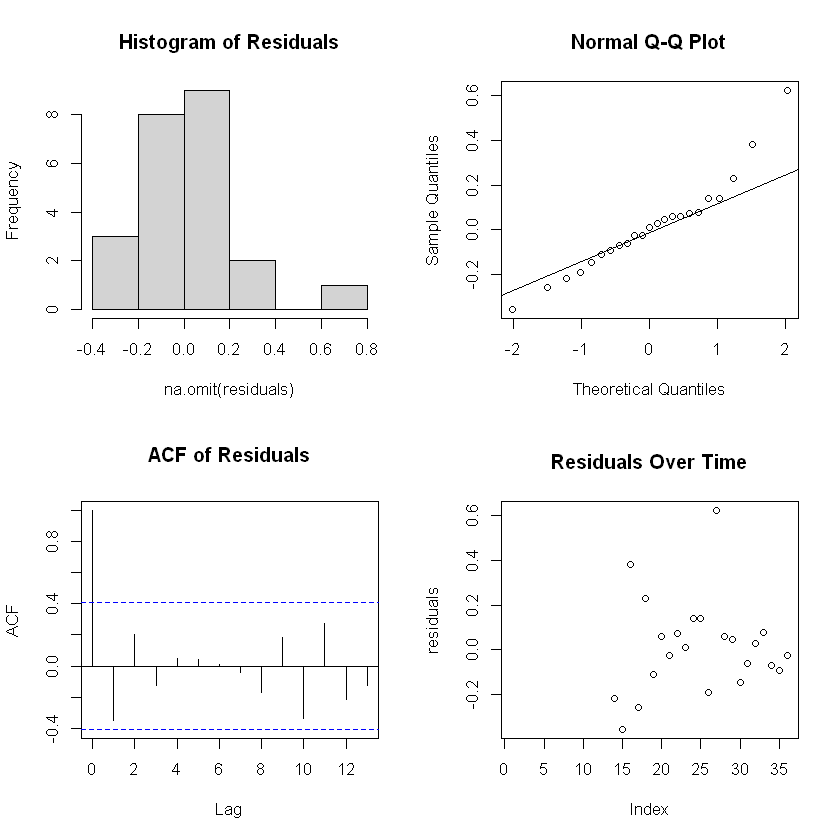

In [51]:
# Initialize residuals
n <- length(Xt)
residuals <- rep(NA, n)

# Loop to compute residuals from t = 14 onwards
for (t in 14:n) {
  residuals[t] <- Xt[t] + phi_1 * Xt[t - 1] + phi_seasonal * Xt[t - 12] +
                  phi_1 * phi_seasonal * Xt[t - 13]
}

# Plot residuals
#par(mfrow = c(2, 2), bg="white")
#ts.plot(residuals, main = "Model Residuals", ylab = "Residuals")

# Check residual diagnostics
par(mfrow = c(2, 2), bg="white")
hist(na.omit(residuals), main = "Histogram of Residuals")
qqnorm(na.omit(residuals)); qqline(na.omit(residuals))
acf(na.omit(residuals), main = "ACF of Residuals")
plot(residuals, main = "Residuals Over Time")


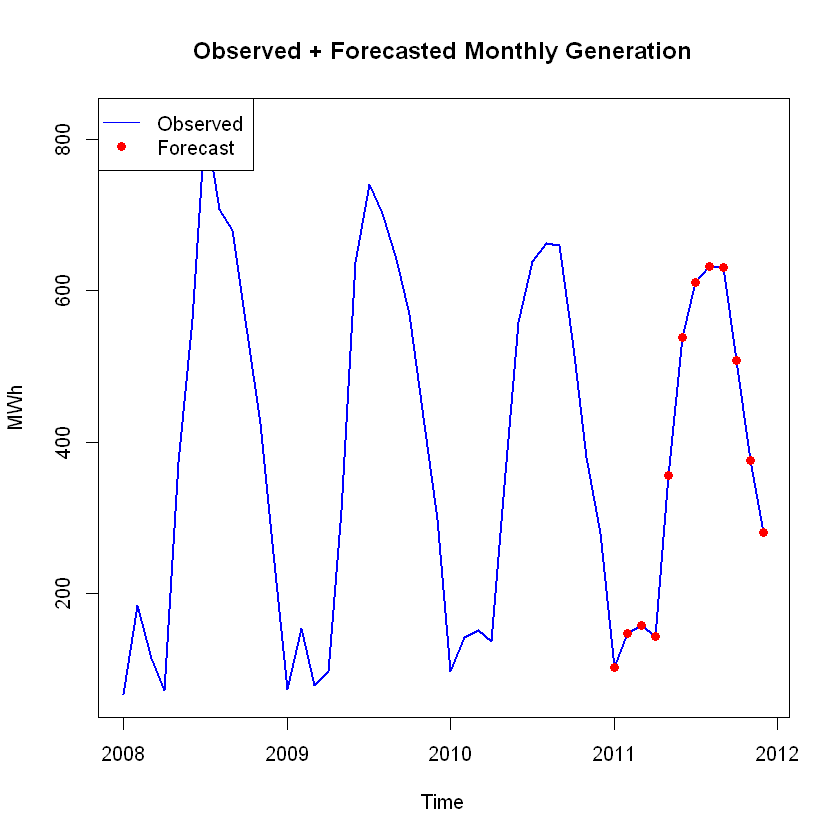

In [52]:
# Forecast Xt for k = 1 to 12
Xt_forecast <- rep(NA, 12)
Xt_ext <- c(Xt, rep(NA, 12))  # extend Xt to hold forecasts

for (k in 1:12) {
  t_k <- length(Xt) + k
  Xt_ext[t_k] <- -phi_1 * Xt_ext[t_k - 1] -
                 phi_seasonal * Xt_ext[t_k - 12] -
                 phi_1 * phi_seasonal * Xt_ext[t_k - 13]
  Xt_forecast[k] <- Xt_ext[t_k]
}

# Transform back to power domain
Y_forecast <- exp(Xt_forecast + mu)

# Combine actual and forecasted
Y_combined <- ts(c(Yts, Y_forecast), start = start(Yts), frequency = 12)

# Plot
par(mfrow = c(1, 1), bg="white")
ts.plot(Y_combined, col = "blue", lwd = 2, main = "Observed + Forecasted Monthly Generation", ylab = "MWh")
points(time(Y_combined)[(length(Yts)+1):(length(Yts)+12)], Y_forecast, col = "red", pch = 19)
legend("topleft", legend = c("Observed", "Forecast"), col = c("blue", "red"), pch = c(NA, 19), lty = c(1, NA))


#### Task 2.1

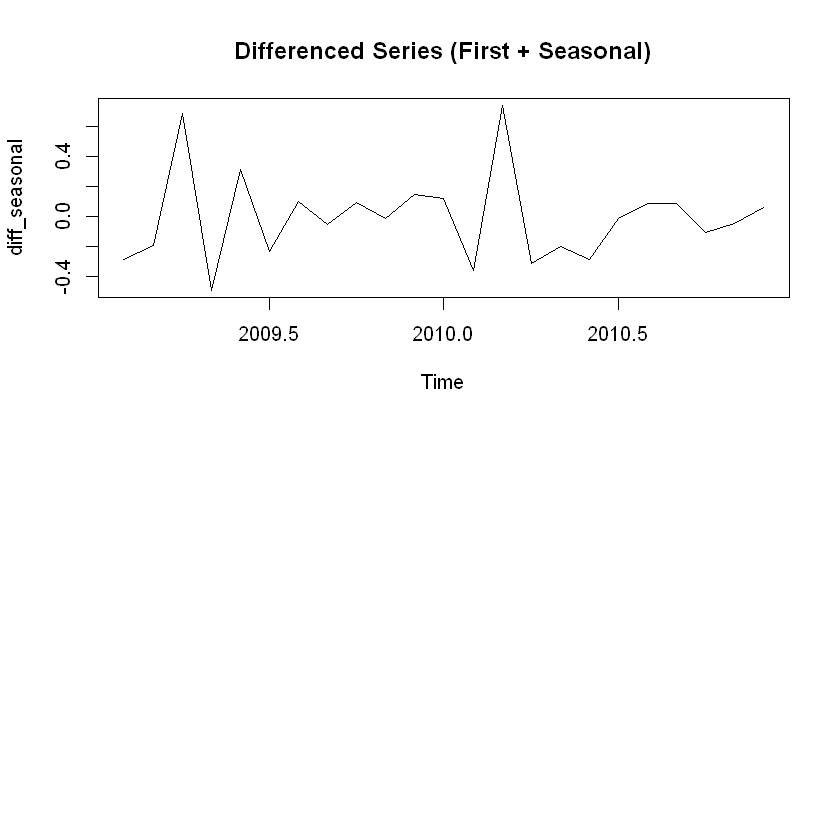

In [53]:
# First-order differencing to remove trend
diff1 <- diff(Xt, differences = 1)

# Seasonal differencing (lag 12) to remove seasonality
diff_seasonal <- diff(diff1, lag = 12)

# Plot to inspect
par(bg="white", mfrow = c(2, 1))
ts.plot(diff_seasonal, main = "Differenced Series (First + Seasonal)")


Website: https://otexts.com/fpp2/arima-r.html

## Diff approach 2.1

In [65]:
library(ggplot2)
library(magrittr)
library(forecast)
library(tseries)

Warning message:
"package 'forecast' was built under R version 4.4.3"
Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Warning message:
"package 'tseries' was built under R version 4.4.3"


In [72]:
# Load data 'datasolar.csv'

files <- dir("functions", full.names = TRUE)
for (i in 1:length(files)) source(files[i])
Y <- read.table("datasolar.csv", sep = ",", header = TRUE)

# Merge 'month' and 'year' columns into 'time'
Y$time <- Y$year + (Y$month - 1) / 12
Yts <- ts(Y[, 3], start = c(Y$year[1], Y$month[1]), frequency = 12)

mu <- 5.72
Xt <- log(Yts) - mu

# Set up AR and seasonal AR parameters
phi_1 <- -0.38
phi_seasonal <- -0.94


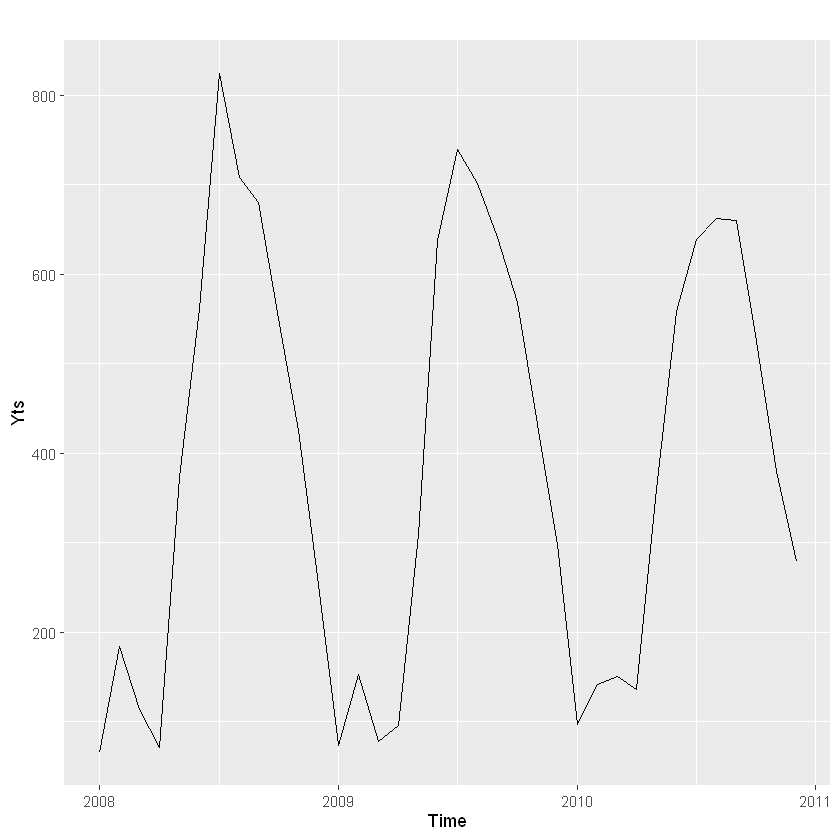

In [67]:
autoplot(Yts)

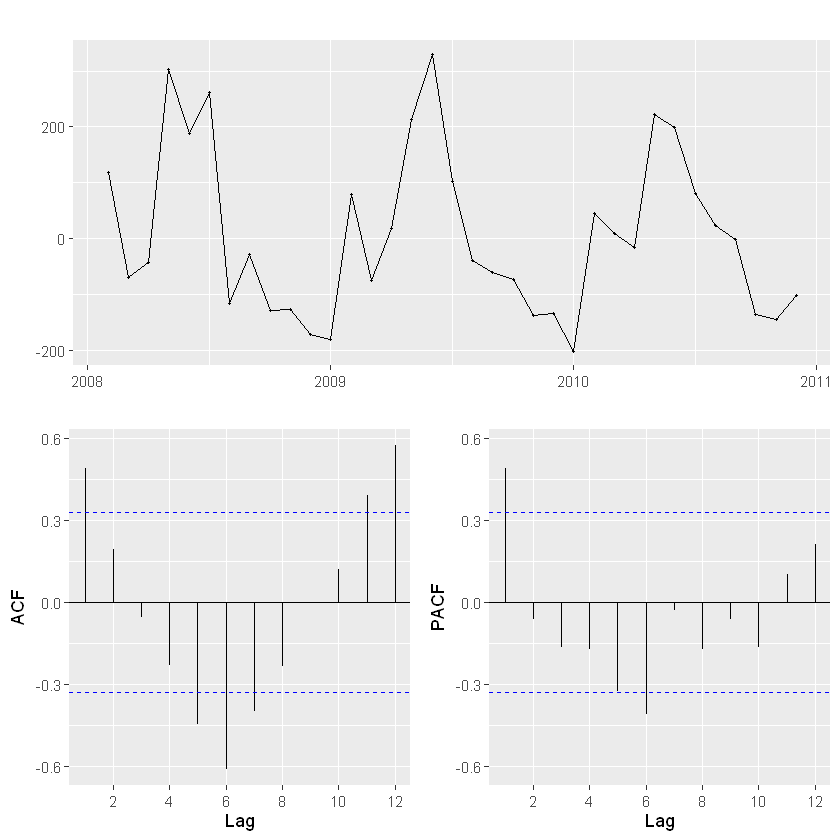

In [68]:
# First differencing to remove trend
Yts %>% diff(lag=1) %>% ggtsdisplay()

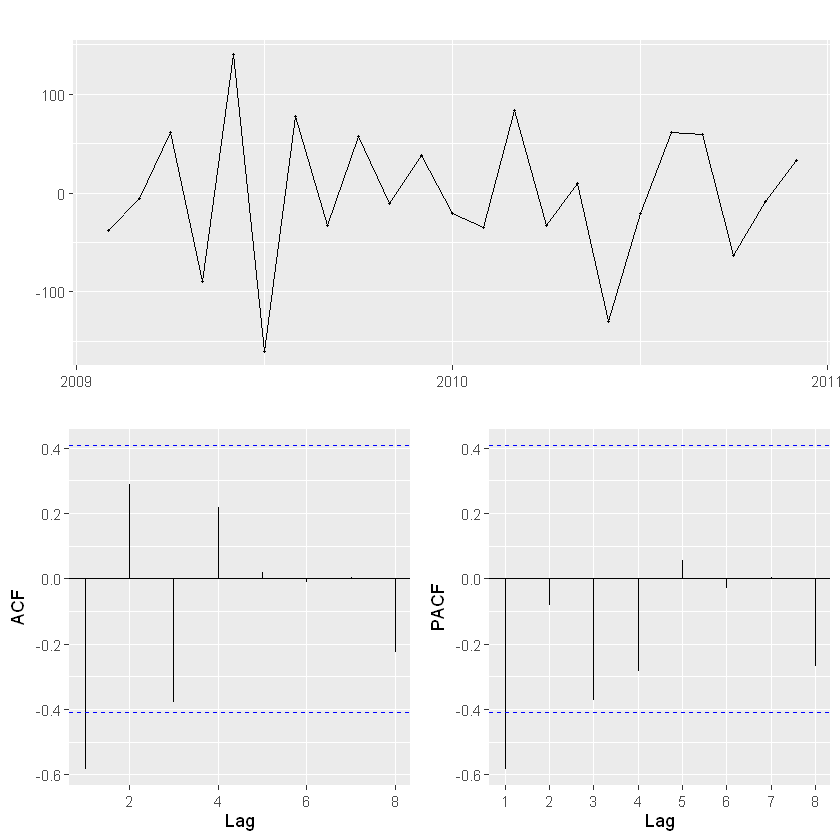

In [70]:
# Seasonal differencing (lag 12) to remove seasonality
Yts %>% diff() %>% diff(lag=12) %>% ggtsdisplay()

In [ ]:
auto.arima(Yts, seasonal = TRUE)

Series: Yts 
ARIMA(0,0,0)(0,1,0)[12] 

sigma^2 = 2396:  log likelihood = -127.43
AIC=256.87   AICc=257.05   BIC=258.04

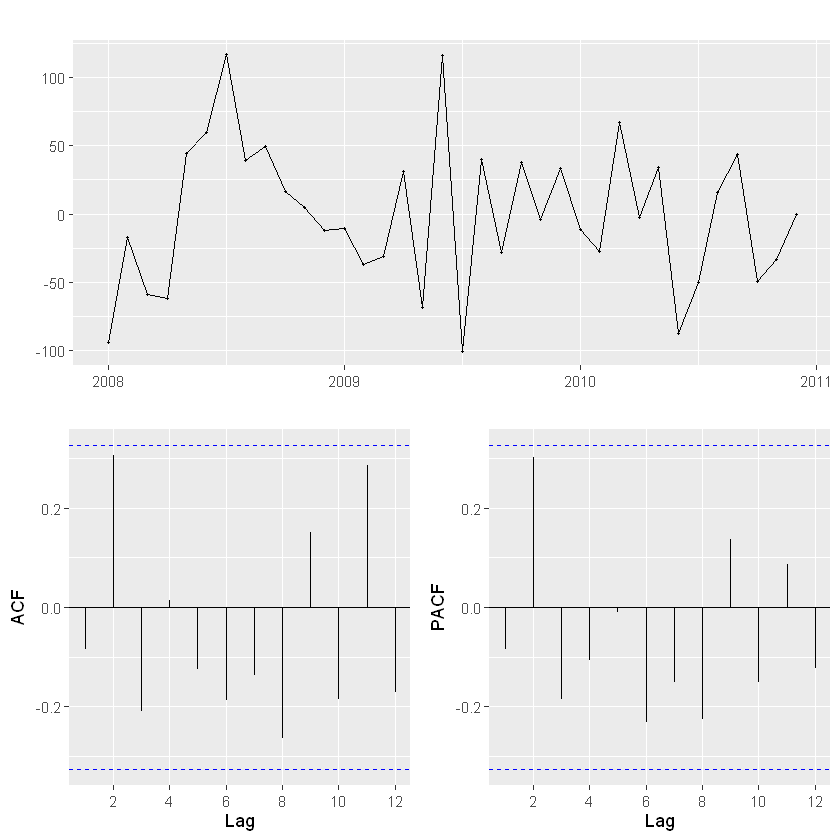

In [ ]:
Yts %>%
  Arima(order=c(1,0,0), seasonal=c(1,0,0)) %>%          # with seasonality - residuals
  residuals() %>% ggtsdisplay()


	Ljung-Box test

data:  Residuals from ARIMA(1,0,0)(1,0,0)[12] with non-zero mean
Q* = 9.0691, df = 5, p-value = 0.1063

Model df: 2.   Total lags used: 7



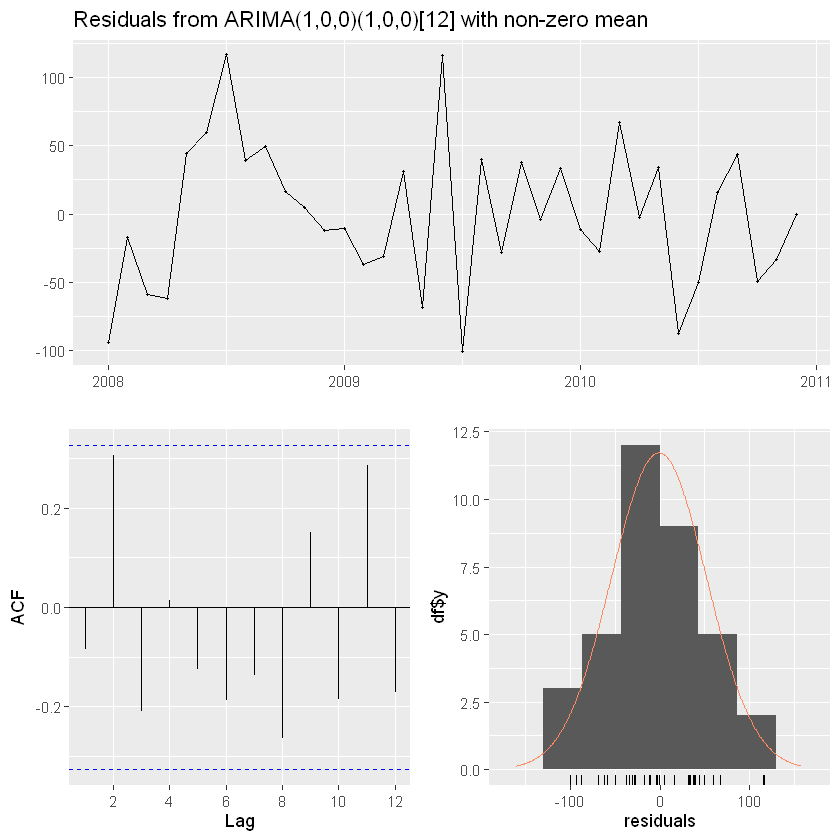

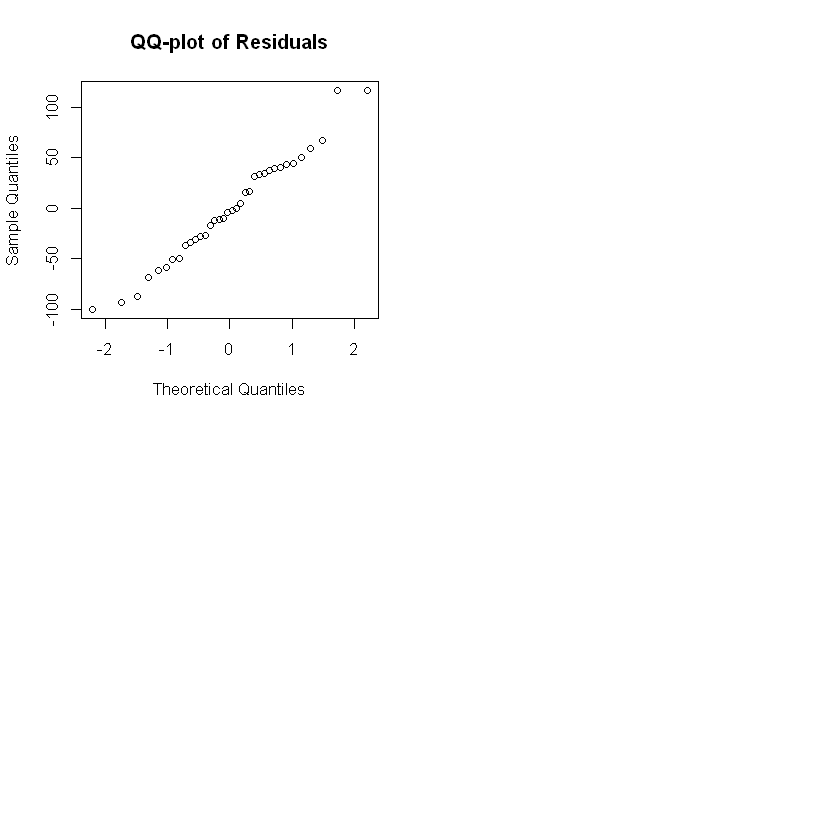

In [77]:
fit12 <- Arima(Yts, order=c(1,0,0), seasonal=c(1,0,0))      # if seasonal =0,0,0, then predictions are bad
checkresiduals(fit12)

# Make a QQ-plot of the residuals
par(mfrow = c(2, 2), bg="white")
qqnorm(residuals(fit12), main="QQ-plot of Residuals")


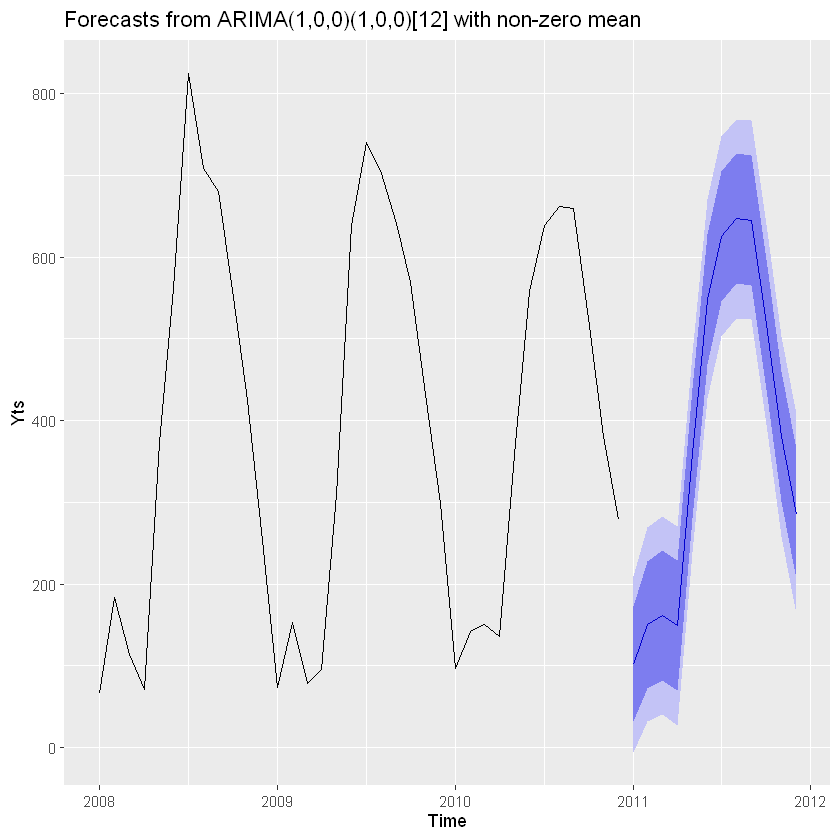

In [78]:
# Forecast the next 12 months
fit12 %>% forecast(h=12) %>% autoplot()

In [81]:
# Forecast 12 months ahead
fit2 <- Arima(Yts, order=c(1,0,0), seasonal=c(0,0,0)) # no seasonality for comparison
fc <- forecast(fit12, h = 12) # try fit12 with seanonality or fit2 without seasonality

# View the full forecast object
print(fc)


         Point Forecast     Lo 80    Hi 80      Lo 95    Hi 95
Jan 2011       101.8417  31.62129 172.0622  -5.551169 209.2346
Feb 2011       150.3537  72.68518 228.0223  31.569932 269.1376
Mar 2011       161.6934  82.45662 240.9301  40.511217 282.8755
Apr 2011       148.8659  69.28305 228.4487  27.154436 270.5774
May 2011       360.1450 280.48502 439.8049 238.315591 481.9744
Jun 2011       548.4194 468.74220 628.0965 426.563660 670.2751
Jul 2011       625.0733 545.39232 704.7543 503.211740 746.9349
Aug 2011       646.8660 567.18412 726.5479 525.003090 768.7289
Sep 2011       645.0084 565.32638 724.6905 523.145242 766.8716
Oct 2011       517.5028 437.82074 597.1849 395.639584 639.3661
Nov 2011       380.5434 300.86129 460.2255 258.680123 502.4067
Dec 2011       285.1425 205.46036 364.8246 163.279200 407.0058


In [ ]:
# Automatic ARIMA model selection
auto.arima(Yts)

Series: Yts 
ARIMA(0,0,0)(1,0,0)[12] with non-zero mean 

Coefficients:
         sar1      mean
      -0.4001  392.6373
s.e.   0.1972    3.8660

sigma^2 = 903.6:  log likelihood = -173.62
AIC=353.23   AICc=353.98   BIC=357.98

## Diff example

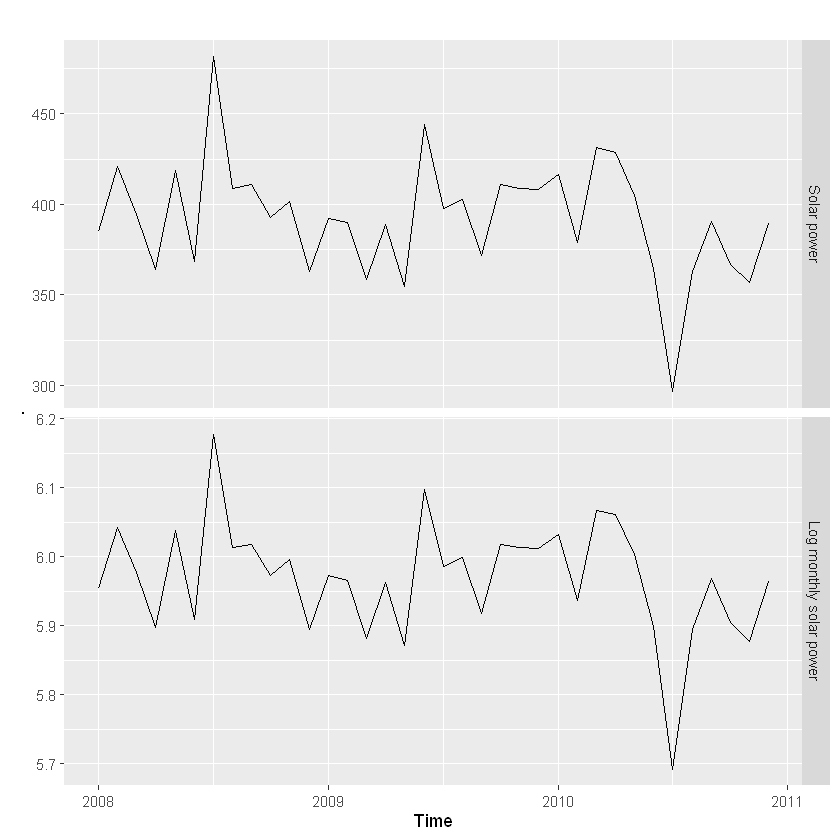

In [ ]:
logY <- log(Yts)
cbind("Solar power" = Yts,
      "Log monthly solar power"=logY) %>%
  autoplot(facets=TRUE)

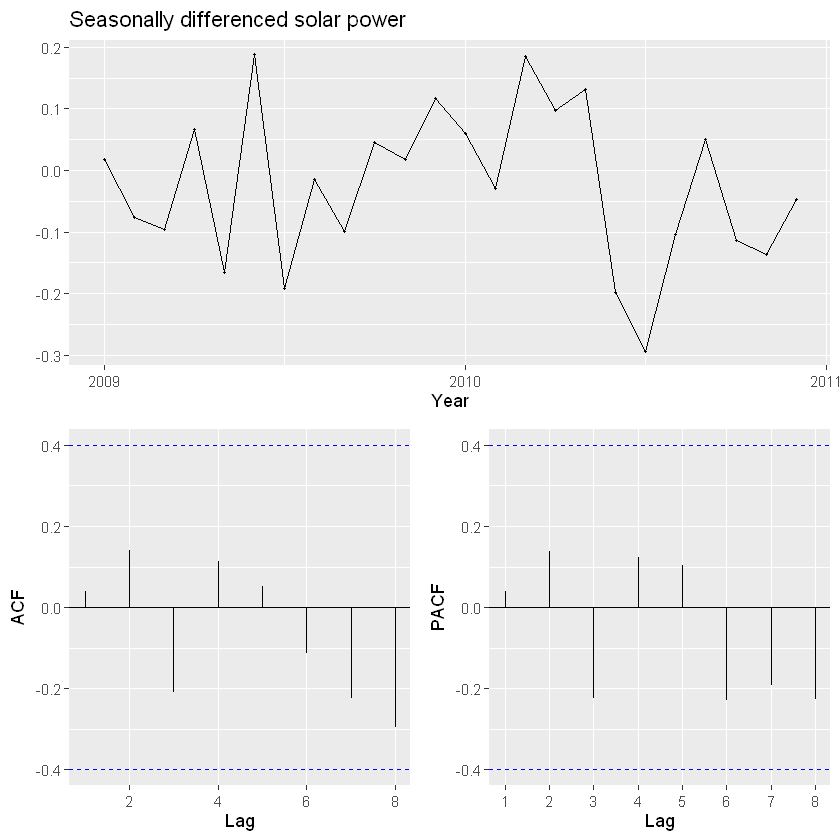

In [ ]:
logY %>% diff(lag=12) %>%
  ggtsdisplay(xlab="Year",
    main="Seasonally differenced solar power")

Series: Yts 
ARIMA(0,0,0)(1,0,0)[12] with non-zero mean 
Box Cox transformation: lambda= 0 

Coefficients:
         sar1    mean
      -0.3973  5.9698
s.e.   0.1990  0.0101

sigma^2 = 0.006106:  log likelihood = 40.69
AIC=-75.38   AICc=-74.63   BIC=-70.63


	Ljung-Box test

data:  Residuals from ARIMA(0,0,0)(1,0,0)[12] with non-zero mean
Q* = NA, df = 35, p-value = NA

Model df: 1.   Total lags used: 36



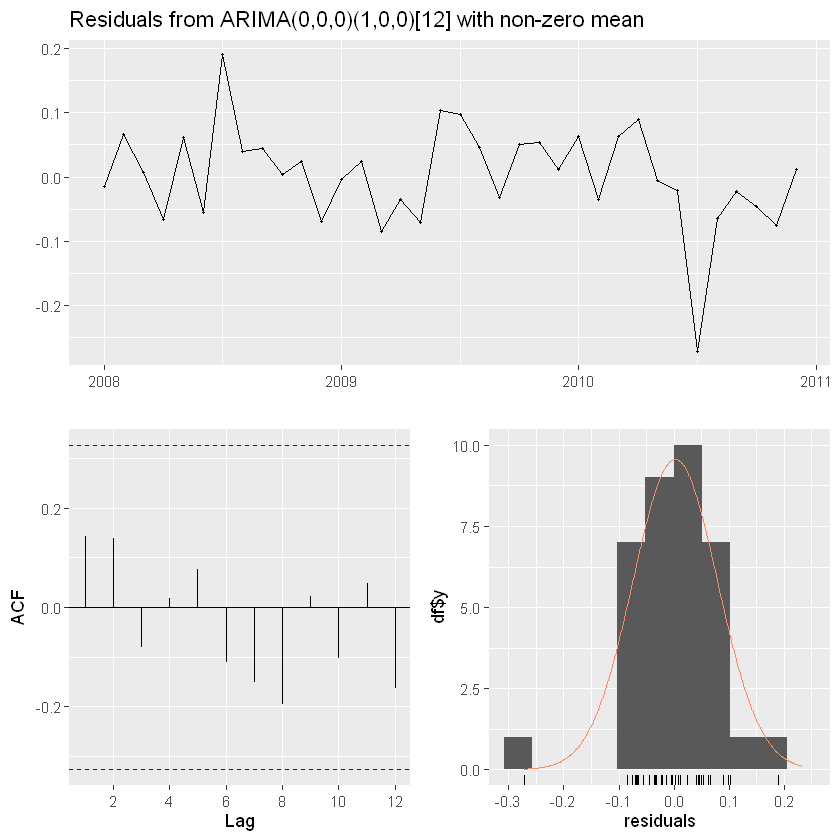

In [ ]:
(fit <- Arima(Yts, order=c(0,0,0), seasonal=c(1,0,0),
  lambda=0))

  checkresiduals(fit, lag=36)

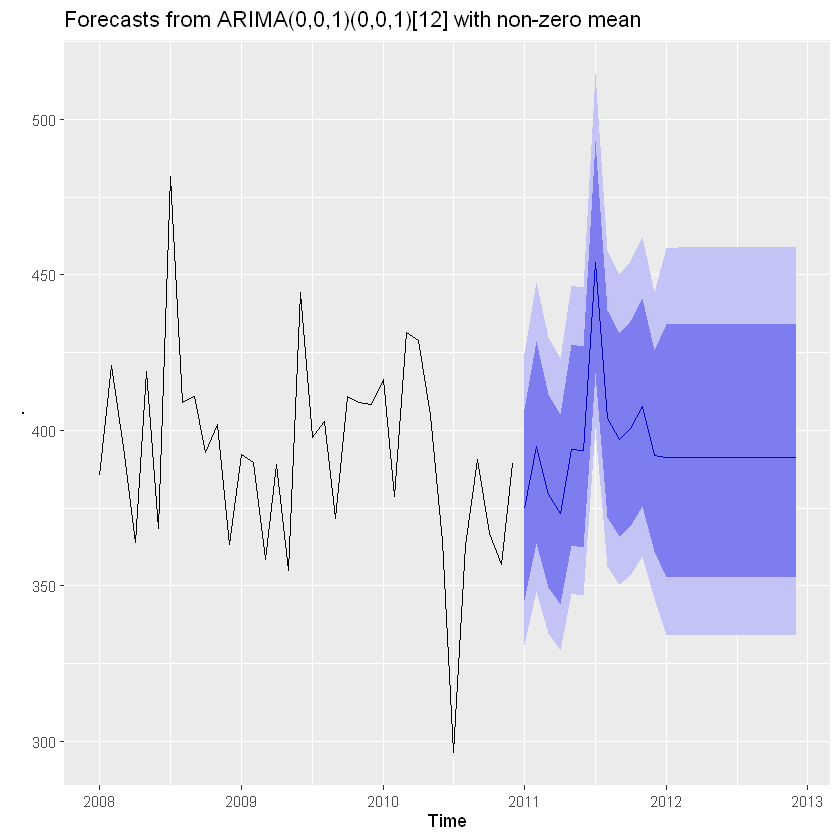

In [ ]:
Yts %>%
  Arima(order=c(0,0,1), seasonal=c(0,0,1), lambda=0) %>%
  forecast() %>%
  autoplot()

### Task 2.2

In [ ]:
# Forecast the next 12 steps
library(forecast)

# Create forecast object
forecast_Xt <- predict(model, n.ahead = 12)

# Extract forecasted X_t values and standard errors
X_hat <- forecast_Xt$pred
se_X <- forecast_Xt$se

# Convert X_t back to Y_t (power):
# Y_hat = exp(X_t + mu)
Y_hat <- exp(X_hat + mu)

# Also calculate 95% prediction intervals
upper_Y <- exp(X_hat + mu + 1.96 * se_X)
lower_Y <- exp(X_hat + mu - 1.96 * se_X)

# Create a data frame with results
forecast_table <- data.frame(
  Month = 1:12,
  X_hat = round(X_hat, 3),
  Y_hat = round(Y_hat, 2),
  Lower_95 = round(lower_Y, 2),
  Upper_95 = round(upper_Y, 2)
)

print(forecast_table)


ERROR: Error: object 'model' not found


In [ ]:
# Extend original series for visual continuity
ts_full <- ts(c(log(Yts) - mu, X_hat), start = start(Yts), frequency = 12)

# Plot original and forecast
ts.plot(ts_full, col = c("black"), main = "Forecasted X_t (log(Y_t) - mu)")
abline(v = time(Yts)[length(Yts)], col = "red", lty = 2)

# Or plot Y_hat with intervals
ts.plot(
  ts(c(Yts, rep(NA, 12)), start = start(Yts), frequency = 12),
  ylim = range(c(Yts, lower_Y, upper_Y)),
  main = "Forecasted Monthly Power Generation (MWh)",
  ylab = "Y_t (MWh)", col = "black"
)
lines(ts(Y_hat, start = c(2011, 1), frequency = 12), col = "blue")
lines(ts(upper_Y, start = c(2011, 1), frequency = 12), col = "darkgreen", lty = 2)
lines(ts(lower_Y, start = c(2011, 1), frequency = 12), col = "darkgreen", lty = 2)


ERROR: Error: object 'X_hat' not found


### Andet

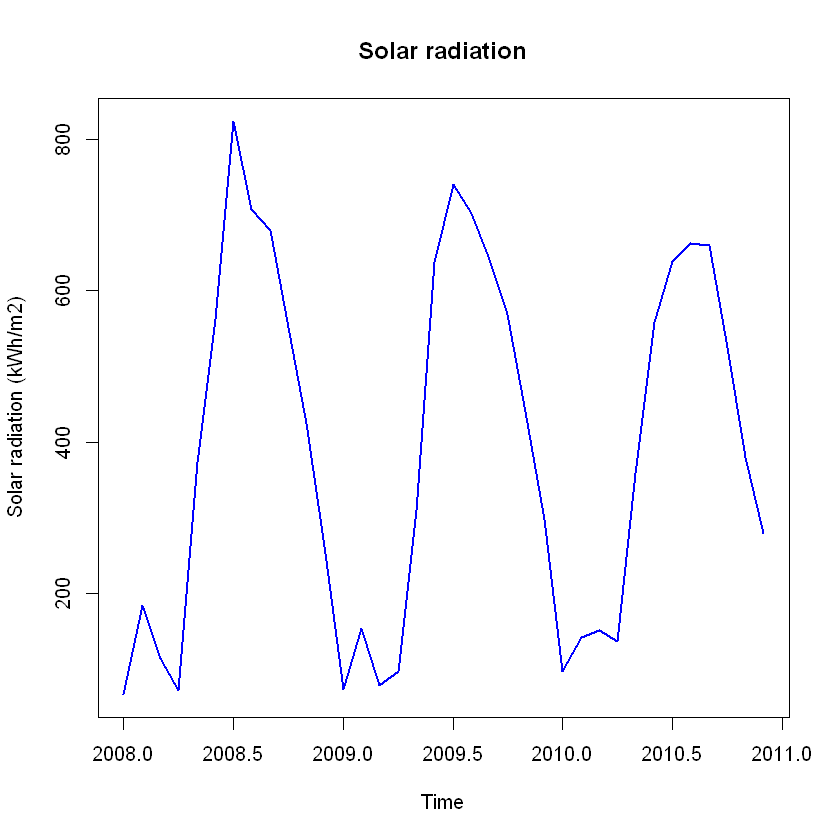

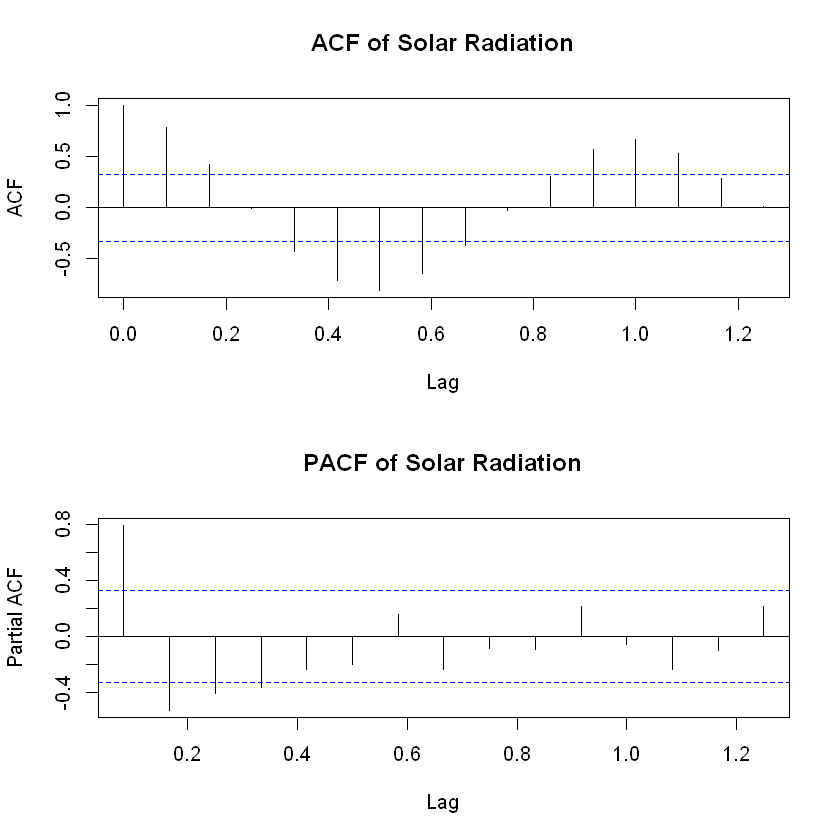

In [ ]:
# Plot the time series - data clean before transformations
par(bg = "white")
plot(Yts, main="Solar radiation", ylab="Solar radiation (kWh/m2)", xlab="Time", col="blue", lwd=2)
# Plot ACF and PACF
par(mfrow=c(2,1))
acf(Yts, main="ACF of Solar Radiation")
pacf(Yts, main="PACF of Solar Radiation")

In [ ]:
# Transformations
# Make log transformation
Yts_T <- log(Yts) # log transformation
Yts_T <- Yts_T - mean(Yts_T) # remove mean 


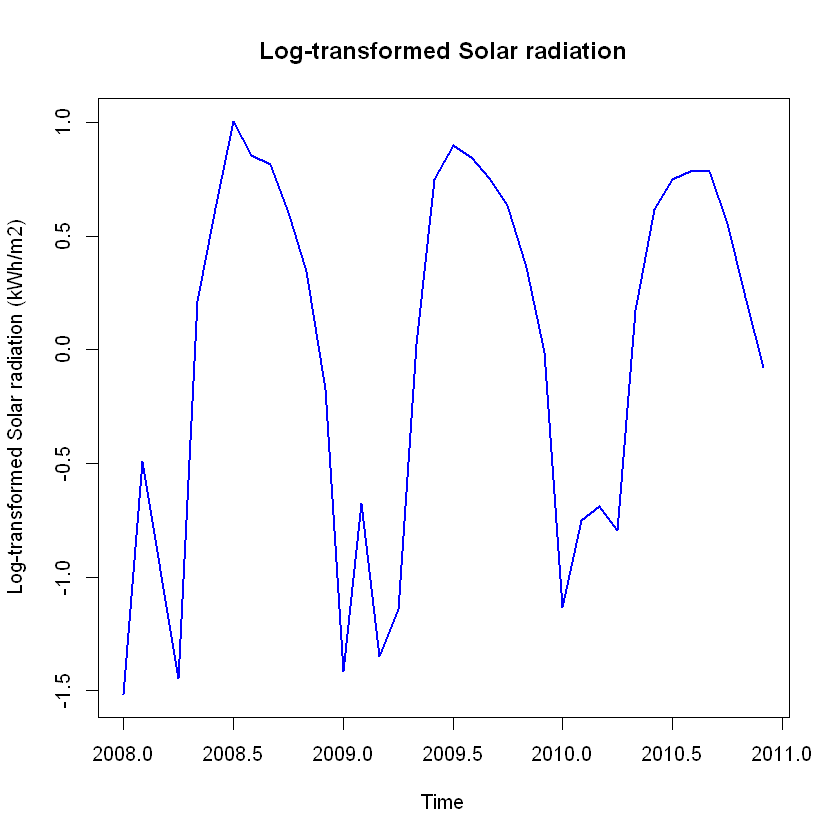

In [ ]:
# Plot transformed data
par(mfrow=c(1,1), bg="white")
plot(Yts_T, 
	 main="Log-transformed Solar radiation", 
	 ylab="Log-transformed Solar radiation (kWh/m2)", 
	 xlab="Time", 
	 col="blue", 
	 lwd=2)



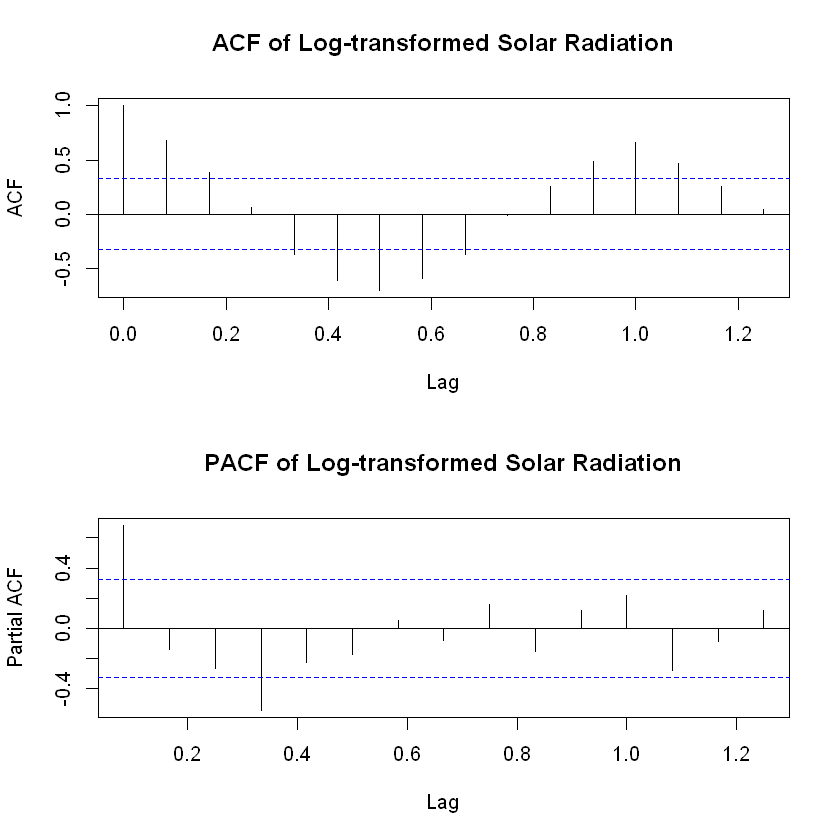

In [ ]:
# Plot ACF and PACF of transformed data
par(mfrow=c(2,1), bg="white")
acf(Yts_T, main="ACF of Log-transformed Solar Radiation")
pacf(Yts_T, main="PACF of Log-transformed Solar Radiation")
# Plot ACF and PACF of transformed data with 95% confidence intervals
par(mfrow=c(2,1), bg="white")
acf(Yts_T, main="ACF of Log-transformed Solar Radiation", ci=0.95)
pacf(Yts_T, main="PACF of Log-transformed Solar Radiation", ci=0.95)